In [ ]:
python -m ipykernel install --user \
  --name audio_poc \
  --display-name "Python (audio_poc)"

In [1]:
import sys
print(sys.executable)

/home/pablo/venvs/audio_poc/bin/python


In [2]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

2.9.1+cu128
True


In [1]:
from datasets import load_dataset

ds = load_dataset("JacobLinCool/VoiceBank-DEMAND-16k")
ds

/home/pablo/venvs/audio_poc/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['id', 'clean', 'noisy'],
        num_rows: 11572
    })
    test: Dataset({
        features: ['id', 'clean', 'noisy'],
        num_rows: 824
    })
})

In [ ]:
from datasets import load_dataset
import numpy as np

ds = load_dataset("JacobLinCool/VoiceBank-DEMAND-16k")
s = ds["train"][0]

assert isinstance(s["noisy"]["array"], np.ndarray)
assert s["noisy"]["sampling_rate"] == 16000

print("OK")

## Precomputed Mel spectograms
The goal is to unify the input training data across different models.
Create a one-time preprocessing step to save all noisy/clean pairs as .pt files

* tqdm gives a progress bar (optional, but handy for large datasets).

* This step is CPU-heavy but done only once.

* You now have all data precomputed → training will no longer compute wav_to_mel on the fly.

If you calculate the log mels on the fly, CPU will be the bottleneck, and GPU usage will be <20% (17% in my case, using a 5060ti 16GB)
If you precompute the log mels and get the pt files, this CPU-heavy process will take <2min (Ryzen 7 7700) and later, during training, the GPU usage will go up to 90% (CPU --> GPU bound)

In [ ]:
from datasets import load_dataset
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F


# 1. Load dataset
'''
VoiceBank-DEMAND: standard speech denoising dataset (16 kHz, noisy-clean pairs)
Data structure: DatasetDict with train and test splits
Each example has: id, clean, noisy
'''
ds = load_dataset("JacobLinCool/VoiceBank-DEMAND-16k")


# 2. Mel-spectrogram transform, inverse, Griffin-Lim
'''
Converts waveform to frequency-time representation: (n_mels, time)

    n_fft → window length for STFT
        (short-time Fourier transform: time-frequency analysis technique
        used to determine the sinusoidal frequency and phase content of
        local sections of a signal as it changes over time)
    hop_length → stride between frames
    n_mels → number of mel bands (human perceptual scale)
    Advantage: reduces dimensionality compared to raw waveform, emphasizes perceptually relevant frequencies.
'''
# mel_transform = torchaudio.transforms.MelSpectrogram(
#     sample_rate=16000,
#     n_fft=1024,
#     hop_length=256,
#     n_mels=80
# )

# inv_mel_transform = torchaudio.transforms.InverseMelScale(
#     n_stft=1024 // 2 + 1,
#     n_mels=80,
#     sample_rate=16000
# )

# griffin_lim = torchaudio.transforms.GriffinLim(
#     n_fft=1024,
#     hop_length=256,
#     n_iter=32
# )


# 3. Helper to convert waveform to log-mel

# def wav_to_mel(wav): # version 2
#     '''
#     Normalized log-mel spectrograms
#         log(mel + 1e-6) → compress dynamic range, typical for audio
#         Transpose: (time, n_mels)
#         Normalization → improves training stability (zero mean, unit variance)
#     Domain note:
#         Spectrogram normalization is common in audio deep learning to help models
#         converge fasterand avoid “exploding gradients”.
#     '''
#     wav = torch.tensor(wav).float()
#     mel = mel_transform(wav)
#     mel = torch.log(mel + 1e-6).transpose(0,1)
#     mel = (mel - mel.mean()) / (mel.std() + 1e-6)

#     T = mel.size(0)
#     if T < MAX_LEN: # new one to handle unet internal downsampling gap issue, e.g. 399 → 199 → 99 → 198 → 396 ❌
#         pad = torch.zeros(MAX_LEN - T, mel.size(1))
#         mel = torch.cat([mel, pad], dim=0)
#     else:
#         mel = mel[:MAX_LEN] # default, working for ripplenet

#     return mel
    

# def mel_to_wav(log_mel): # skip perfect denormalization (acceptable for now)
#     """
#     log_mel: (time, n_mels)
#     returns waveform tensor
#     """
#     mel = torch.exp(log_mel.transpose(0, 1))  # back to (n_mels, time)
#     spec = inv_mel_transform(mel)
#     wav = griffin_lim(spec)
#     return wav

n_fft = 1024
hop_length = 256
win_length = 1024
window = torch.hann_window(win_length)

MAX_LEN = 256  # frames
EPS = 1e-6

def wav_to_stft_mag_phase(wav):
    """
    wav: 1D numpy array or tensor
    returns:
        log_mag: (T, F)
        phase:   (F, T)
    """
    wav = torch.tensor(wav).float()

    stft = torch.stft(
        wav,
        n_fft=n_fft,
        hop_length=hop_length,
        win_length=win_length,
        window=window,
        return_complex=True
    )  # (F, T)

    mag = torch.abs(stft)
    phase = torch.angle(stft)

    log_mag = torch.log(mag + EPS).transpose(0, 1)  # (T, F)

    # Normalize per-sample (important!)
    log_mag = (log_mag - log_mag.mean()) / (log_mag.std() + EPS)

    T = log_mag.size(0)
    if T < MAX_LEN:
        pad = torch.zeros(MAX_LEN - T, log_mag.size(1))
        log_mag = torch.cat([log_mag, pad], dim=0)
        phase = F.pad(phase, (0, MAX_LEN - phase.size(1)))
    else:
        log_mag = log_mag[:MAX_LEN]
        phase = phase[:, :MAX_LEN]

    return log_mag, phase

def stft_mag_phase_to_wav(log_mag, phase):
    """
    log_mag: (T, F)
    phase:   (F, T)
    """
    mag = torch.exp(log_mag.transpose(0, 1))  # (F, T)

    complex_stft = mag * torch.exp(1j * phase)

    wav = torch.istft(
        complex_stft,
        n_fft=n_fft,
        hop_length=hop_length,
        win_length=win_length,
        window=window,
        length=MAX_LEN * hop_length
    )

    return wav


import os
from tqdm import tqdm


# using Griffin-lim (objective mismatch)

# os.makedirs("precomputed_mels/train", exist_ok=True)
# os.makedirs("precomputed_mels/test", exist_ok=True)
# for split in ["train", "test"]:
#     for i, sample in enumerate(tqdm(ds[split])):
#         noisy_mel = wav_to_mel(sample["noisy"]["array"])
#         clean_mel = wav_to_mel(sample["clean"]["array"])
#         torch.save((noisy_mel, clean_mel), f"precomputed_mels/{split}/{i}.pt")

# using STFT
os.makedirs("precomputed_stft/train", exist_ok=True)
os.makedirs("precomputed_stft/test", exist_ok=True)

for split in ["train", "test"]:
    for i, sample in enumerate(tqdm(ds[split])):
        noisy_mag, noisy_phase = wav_to_stft_mag_phase(sample["noisy"]["array"])
        clean_mag, _ = wav_to_stft_mag_phase(sample["clean"]["array"])

        torch.save(
            (noisy_mag, noisy_phase, clean_mag),
            f"precomputed_stft/{split}/{i}.pt"
        )


/home/pablo/venvs/audio_poc/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
class RippleWaveBlock(nn.Module):
    '''
    Intuition Behind RippleWave
    1. Frequency-wise coupling:
        - Each frequency channel interacts with neighbors → smoother, physically consistent spectral evolution.

    2. Temporal consistency:
        - u_prev keeps track of the previous step → avoids frame-by-frame independent predictions,
        mimicking temporal continuity in real waves.
    
    3. Minimal parameters:
        - Only 1 Conv1d + damping → small model, fast inference, ideal for POC.
    
    4. Potential improvement:
        - Multiple propagation steps → captures longer temporal dependencies.
        - Deeper convolutions → wider receptive field along time.
    '''
    
    def __init__(self, n_freq, kernel_size=5):
        super().__init__()
        self.conv = nn.Conv1d(
            in_channels=n_freq,
            out_channels=n_freq,
            kernel_size=kernel_size,
            padding=kernel_size // 2
        )
        self.damping = nn.Parameter(torch.tensor(0.05))
        self.alpha = nn.Parameter(torch.tensor(0.05))
        # self.alpha = torch.clamp(self.alpha, 0.01, 0.1)
        # self.damping = torch.clamp(self.damping, 0.01, 0.1)



    def forward(self, x, u_prev=None):
        x = x.transpose(1,2)  # (batch, F, time T)
        if u_prev is None:
            u_prev = torch.zeros_like(x) # reset every block
        u = x

        # 1. simulate discrete wave dynamics with a Conv1d layer approximating the spatial Laplacian,
        # which measures how much a point differs from its neighbors:
            # 1.1 self.conv(u) = neighbors influence
            # 1.2 Subtract u = current state
            # 1.3 Laplacian drives propagation like in heat diffusion or wave PDEs
        # lap = self.conv(u) - u
        lap = self.alpha * (self.conv(u) - u)

        # 2. compute a single-step update using a discretized wave equation:
            # 2.1: 2*u - u_prev → classical wave propagation term (from finite difference in time)
            # 2.2: lap → local interactions between frequencies
            # 2.3: damping * (u - u_prev) → reduces oscillation (prevents divergence)
            # 2.4: Output is u_new → denoised spectrogram approximation.
        u_new = 2*u - u_prev + lap - self.damping * (u - u_prev)
        '''
        We are simulating a wave equation without a stability constraint
        Our core update:
        This is a second-order explicit time integrator.
        In numerical PDEs, this requires a CFL condition:
            If the effective step size or kernel energy is too large → divergence
        In neural terms:
            Conv1d weights grow slowly during training
            At some point, lap = conv(u) - u becomes too energetic
            One batch pushes the system over stability
            Boom → NaNs / huge values → optimizer amplifies them
        '''
        # prevent blow-up
        # u_new = torch.tanh(u_new)
        # u_new = F.relu(u_new) # ReLU ensures non-negative output

        # clamp to prevent blow-up
        u_new = torch.clamp(u_new, 0.0, 1.0)  # since inputs normalized ~[0,0.4]

        # OR
        # u_new = torch.clamp(u_new, -5.0, 5.0)

        return u_new.transpose(1,2)
    
class RippleWaveNet(nn.Module):
    '''
    Input: (batch, time, n_mels)
    Transpose → (batch, n_mels, time) for Conv1d along time
    Compute discrete Laplacian, single-step wave propagation with damping
    Output → denoised spectrogram (batch, time, n_mels)

    Physics analogy:
        u_prev ↔ previous state
        lap ↔ local spatial derivative
        damping ↔ energy dissipation in real waves
    '''
    def __init__(self, n_freq=513, n_blocks=6, kernel_size=5):
        super().__init__()
        self.blocks = nn.ModuleList(
            [RippleWaveBlock(n_freq, kernel_size) for _ in range(n_blocks)]
        )

    def forward(self, x):
        # u_prev = torch.zeros_like(x) # initial previous state
        u_prev = None
        out = x
        for block in self.blocks:
            # x = block(x) # original
            out = block(out, u_prev) # returns (B, T, F)
            u_prev = out.transpose(1,2) # keep temporal continuity, save as (B, F, T) for next block
        return out + x # residual connection
        

class UNetBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )

    def forward(self, x):
        return self.conv(x)


class UNetSmall(nn.Module):
    def __init__(self, n_mels=80):
        super().__init__()
        self.enc1 = UNetBlock(1, 128)
        self.enc2 = UNetBlock(128, 256)
        self.enc3 = UNetBlock(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.dec1 = UNetBlock(512, 256)
        self.dec2 = UNetBlock(256, 128)
        self.dec3 = UNetBlock(128, 1)

    def forward(self, x):
        x = x.unsqueeze(1) # (B, 1, T, M)

        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        # Decoder
        d1 = F.interpolate(e3, scale_factor=2, mode="nearest")
        d1 = self.dec1(d1)
        d2 = F.interpolate(d1, scale_factor=2, mode="nearest")
        d2 = self.dec2(d2)
        out = self.dec3(d2)

        return out.squeeze(1) # (B, T, M)


from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim

def collate_fn(batch):
    # version 3 (simplified, since padding handled in wav_to_mel)
    # noisy_list, clean_list = zip(*batch)
    # noisy_padded = torch.stack(noisy_list)
    # clean_padded = torch.stack(clean_list)

    # version 4 (handling stft instead of mel)
    noisy_list, phase_list, clean_list = zip(*batch)
    noisy = torch.stack(noisy_list)   # (B, T, F)
    phase = torch.stack(phase_list)   # (B, F, T)
    clean = torch.stack(clean_list)   # (B, T, F)

    return noisy, phase, clean

# -------------------------------------------------------------------------
# -------------------------------------------------------------------------
# -------------------------------------------------------------------------

class PrecomputedMelDataset(Dataset):
    '''
    Usage: use this class if you have precomputed mel-spectrograms saved as .pt files
    '''
    # version 1 MSE
    # def __init__(self, split="train"):
    #     self.path = f"precomputed_mels/{split}"
    #     self.files = sorted(os.listdir(self.path))  # ensure consistent order

    # def __len__(self):
    #     return len(self.files)

    # def __getitem__(self, idx):
    #     return torch.load(os.path.join(self.path, self.files[idx]))

    # version 2
    def __init__(self, split="train"):
        self.files = sorted(os.listdir(f"precomputed_stft/{split}"))
        self.split = split

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        noisy_mag, noisy_phase, clean_mag = torch.load(
            f"precomputed_stft/{self.split}/{idx}.pt"
        )
        return noisy_mag, noisy_phase, clean_mag


# 1. Custom Dataset for spectrograms
class VoiceDataset(Dataset):
    '''
    Usage: use this class if you want to compute mel-spectrograms on-the-fly

    Initially converts each audio pair to mel-spectrogram. Now it uses STFT
    Returns (noisy, clean) pair + noisy_phase
    collate_fn pads sequences to max length in batch, handles variable-length audio

    Domain note:
        Speech utterances vary in length → padding + masking is needed for batch training
        Using pad_sequence ensures tensors align for batch matrix operations
    '''
    # version 1
    def __init__(self, split="train"):
        self.ds = ds[split]
    
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        s = self.ds[idx]
        noisy = wav_to_mel(s["noisy"]["array"])
        clean = wav_to_mel(s["clean"]["array"])
        return noisy, clean
    

BATCH_SIZE = 16
EPOCHS = 16

# ------------ train logs ------------
# unet (small)
# 16 batch, 2 epoch --> 3min without precomputed mel (on-the-fly)
# 16 batch, 2 epoch --> 40s with precomputed mel
# ripplenet (small)
# 16 batch, 2 epoch --> 2min without precomputed mel (on-the-fly)
# 16 batch, 2 epoch --> ?? with precomputed mel


# unet (mid size, 512, 3 blocks, 8.6GB GPU VRAM usage, peak 100%)
# 16 batch, 16 epoch
#   --> 38.5 min with precomputed mel
# Epoch 16/16 | Train Loss: 0.3508 | Val Loss: 0.3125
#   --> performance: bad, not recognizable

# ripplenet (mid size, kernel=5, 6 blocks, 8.6GB GPU VRAM usage, peak 45%)
# 16 batch, 16 epoch
# Epoch 16/16 | Train Loss: 0.1929 | Val Loss: 0.1205
#   --> 1min6s with precomputed mel
#   --> performance: bad, not recognizable

# ripplenet (mid size, kernel=5, 6 blocks, peak 45%)
# wav_to_stft_mag_phase instead of mel, instead of MSE we use combined MSE + L1
# result --> explode gradients after 7 epochs
    # --> performance: silence, expected due to gradient explosion

# ripplenet (mid size, kernel=5, 6 blocks, peak 78%)
#   --> 6min20s, in RippleWaveBlock forward, instead of MSE we use combined MSE + L1
# wav_to_stft_mag_phase instead of mel, instead of MSE we use combined MSE + L1
# Epoch 16/16 | Train Loss: 0.1983 | Val Loss: 0.1855
    # --> performance: bad, robotic, not recognizable

# ripplenet (mid size, kernel=5, 6 blocks, peak %)
# --> 6min22s
# | Change                         | Why                                                       |
# | ------------------------------ | --------------------------------------------------------- |
# | `u_prev` passed between blocks | Temporal consistency (waves evolve smoothly)              |
# | Clamp instead of `ReLU`/`tanh` | Keep outputs non-negative like STFT magnitudes            |
# | Input normalization  through low alpha and low damping contansts toa void big gradients or NaN |
# | Residual connection            | Preserves input structure, stabilizes training
# Epoch 16/16 | Train Loss: 0.3668 | Val Loss: 0.2254         |
# --> performance: intelligible, although not noise reduction. loud inferences
# ------------------------------------

train_loader = DataLoader(
    PrecomputedMelDataset("train"),
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    PrecomputedMelDataset("test"),
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn
)

# only use this loader if you don't have precomputed mels files
# train_loader = DataLoader(
#     VoiceDataset("train"), 
#     batch_size=BATCH_SIZE, 
#     shuffle=True, 
#     collate_fn=collate_fn
# )
# test_loader = DataLoader(
#     VoiceDataset("test"), 
#     batch_size=BATCH_SIZE, 
#     collate_fn=collate_fn
# )


# 2. Model + optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = RippleWaveNet().to(device) #RippleWaveBlock()
# model = UNetSmall().to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4) #1e-3)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, factor=0.5, patience=2
# )
# criterion = nn.MSELoss()
'''note: MSE is objective mismatch. What I asked the model to learn
    is not aligned with audio quality. Two mel spectrograms that are very close
    in MSE can reconstruct to completely different (or unusable) waveforms
    with Griffin-Lim. So we need to use STFT magnitude + noisy phase.
Key idea used in classic speech enhancement (before neural vocoders):
Phase matters far more than people think
Using the noisy phase is vastly better than Griffin-Lim
'''
def loss_fn(pred, target):
    mse = F.mse_loss(pred, target)
    l1 = F.l1_loss(pred, target)
    return mse + 0.1 * l1

def normalize_mag(mag):
    # mag: STFT magnitude (B, T, F)
    return torch.log1p(mag) / 10.0  # scales roughly to [0,1] range

def denormalize_mag(pred):
    return torch.expm1(pred * 10.0)


# 3. Training loop

from torch.utils.tensorboard import SummaryWriter
from torch.nn.utils import clip_grad_norm_
writer = SummaryWriter(log_dir="runs/ripple_poc")

for epoch in range(EPOCHS): # version 1
    model.train()
    train_loss = 0
    for i, (noisy, _, clean) in enumerate(train_loader):
        '''
        Loss: MSE → standard for log-mel spectrogram regression --> prove to be bad metric for audio quality
        Alternative: combined MSE + L1 → encourages both overall structure (MSE) and fine details (L1)
        Optimizer: Adam → adaptive learning, handles small parameter updates efficiently
        '''
        noisy = noisy.to(device)
        clean = clean.to(device)
        # noisy = normalize_mag(noisy).to(device) # Normalize magnitudes before feeding the model
        # clean = normalize_mag(clean).to(device)

        optimizer.zero_grad()
        out = model(noisy)
        # loss = criterion(out, clean) # original using MSE
        loss = loss_fn(out, clean)
        loss.backward()

        # -----------------------------
        # GRADIENT CLIPPING
        # Prevents exploding gradients in RippleWaveNet
        clip_grad_norm_(model.parameters(), max_norm=1.0)
        # -----------------------------

        optimizer.step()
        train_loss += loss.item() * noisy.size(0)  # accumulate sum for averaging

        if i % 100 == 0:  # print every 100 batches
            print(f"Batch {i}/{len(train_loader)} | Loss: {loss.item():.4f}")        

    # log epoch loss
    train_loss /= len(train_loader.dataset) # average per sample
    writer.add_scalar("Loss/train_epoch", train_loss, epoch)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for noisy, _, clean in test_loader:
            noisy = noisy.to(device)
            clean = clean.to(device)
            # noisy = normalize_mag(noisy).to(device) # Normalize magnitudes before feeding the model
            # clean = normalize_mag(clean).to(device)

            out = model(noisy)
            # loss = criterion(out, clean) # original using MSE
            loss = loss_fn(out, clean)
            val_loss += loss.item() * noisy.size(0)

    val_loss /= len(test_loader.dataset)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

Batch 0/724 | Loss: 0.6798
Batch 100/724 | Loss: 0.3312
Batch 200/724 | Loss: 0.3073
Batch 300/724 | Loss: 0.3249
Batch 400/724 | Loss: 0.3811
Batch 500/724 | Loss: 0.4500
Batch 600/724 | Loss: 0.4414
Batch 700/724 | Loss: 0.4070
Epoch 1/16 | Train Loss: 0.4017 | Val Loss: 0.2315
Batch 0/724 | Loss: 0.3698
Batch 100/724 | Loss: 0.4177
Batch 200/724 | Loss: 0.3831
Batch 300/724 | Loss: 0.3554
Batch 400/724 | Loss: 0.3990
Batch 500/724 | Loss: 0.3694
Batch 600/724 | Loss: 0.3402
Batch 700/724 | Loss: 0.3362
Epoch 2/16 | Train Loss: 0.3891 | Val Loss: 0.2306
Batch 0/724 | Loss: 0.4015
Batch 100/724 | Loss: 0.3592
Batch 200/724 | Loss: 0.4102
Batch 300/724 | Loss: 0.2749
Batch 400/724 | Loss: 0.3659
Batch 500/724 | Loss: 0.4107
Batch 600/724 | Loss: 0.3971
Batch 700/724 | Loss: 0.3390
Epoch 3/16 | Train Loss: 0.3845 | Val Loss: 0.2277
Batch 0/724 | Loss: 0.3317
Batch 100/724 | Loss: 0.3529
Batch 200/724 | Loss: 0.4204
Batch 300/724 | Loss: 0.4001
Batch 400/724 | Loss: 0.3284
Batch 500/724 

In [67]:
device

device(type='cuda')

In [76]:
# Save
torch.save(model.state_dict(), "ripplenet_scaled.pth")

# Reload later
# 1. Recreate the model architecture
# model_reloaded = UNetSmall(n_mels=80)
# # 2. Load parameters
# model_reloaded.load_state_dict(torch.load("unet_scaled.pth", map_location=device))
# model_reloaded.to(device)
# model_reloaded.eval()  # set to evaluation mode

In [58]:
unetmodel = model
unetmodel

UNetSmall(
  (enc1): UNetBlock(
    (conv): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
  )
  (enc2): UNetBlock(
    (conv): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dec1): UNetBlock(
    (conv): Sequential(
      (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
  )
  (dec2): UNetBlock(
    (conv): Sequential(
      (0): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(1, 1, kernel_

In [44]:
ripplemodel = model
ripplemodel

RippleWaveNet(
  (blocks): ModuleList(
    (0-2): 3 x RippleWaveBlock(
      (conv): Conv1d(80, 80, kernel_size=(3,), stride=(1,), padding=(1,))
    )
  )
)

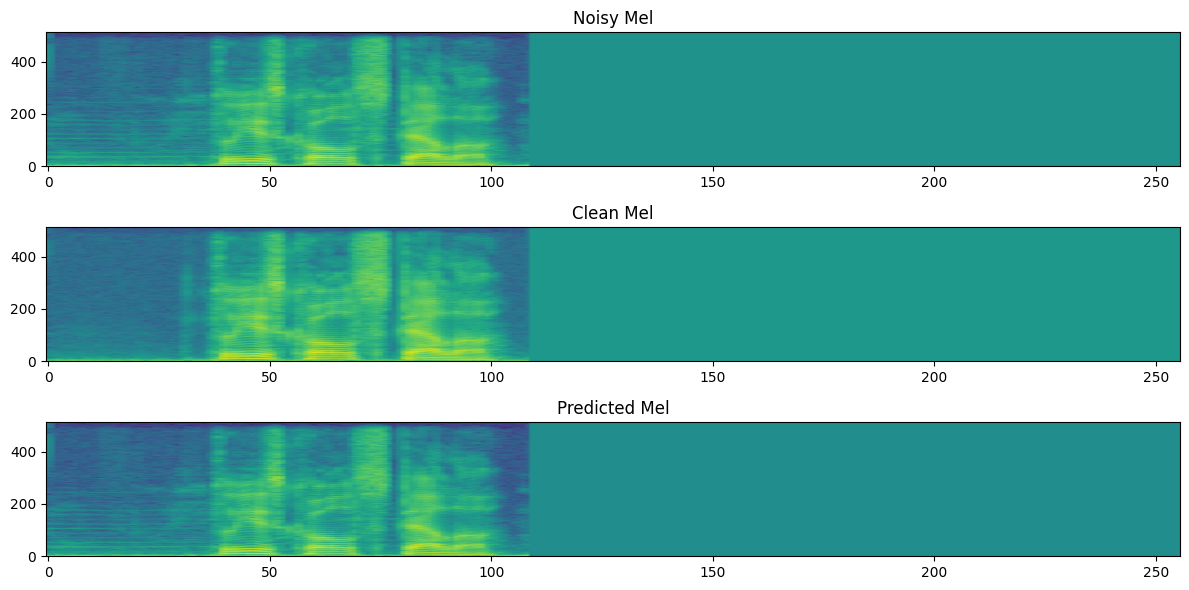

In [11]:
import matplotlib.pyplot as plt

# Pick a test sample
noisy, _, clean = next(iter(test_loader))
noisy = noisy.to(device)
out = model(noisy)

# Convert tensors to numpy for plotting
noisy_np = noisy[0].detach().cpu().numpy()
clean_np = clean[0].detach().cpu().numpy()
out_np = out[0].detach().cpu().numpy()

# Plot
plt.figure(figsize=(12,6))
plt.subplot(3,1,1)
plt.title("Noisy Mel")
plt.imshow(noisy_np.T, aspect='auto', origin='lower')
plt.subplot(3,1,2)
plt.title("Clean Mel")
plt.imshow(clean_np.T, aspect='auto', origin='lower')
plt.subplot(3,1,3)
plt.title("Predicted Mel")
plt.imshow(out_np.T, aspect='auto', origin='lower')
plt.tight_layout()
plt.show()


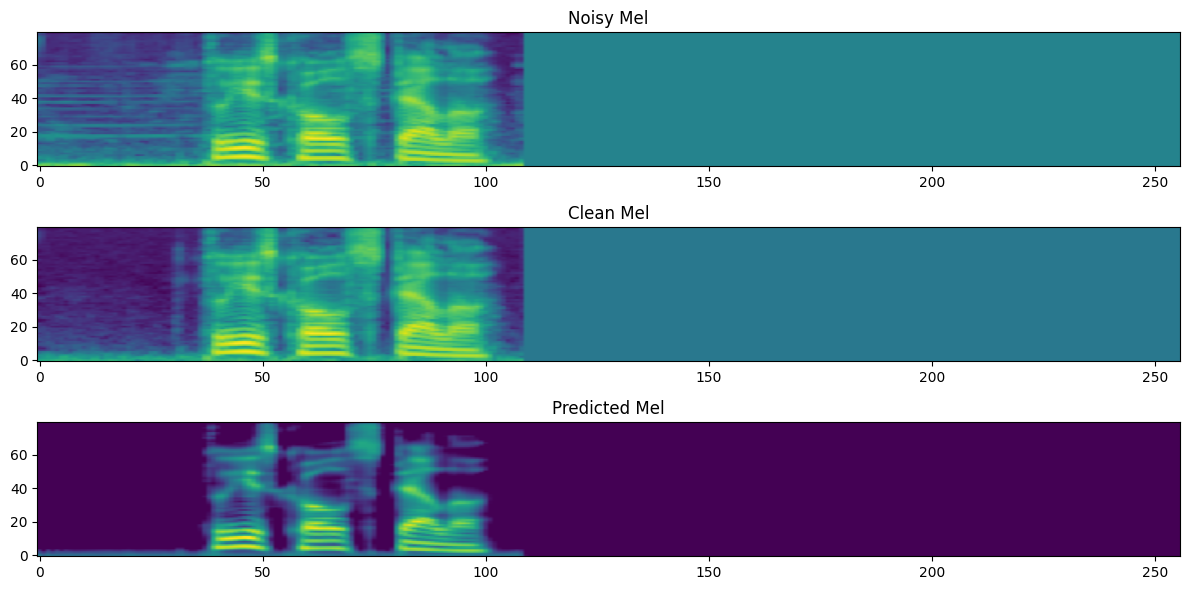

In [71]:
import matplotlib.pyplot as plt

# Pick a test sample
noisy, clean = next(iter(test_loader))
noisy = noisy.to(device)
out = model(noisy)

# Convert tensors to numpy for plotting
noisy_np = noisy[0].detach().cpu().numpy()
clean_np = clean[0].detach().cpu().numpy()
out_np = out[0].detach().cpu().numpy()

# Plot
plt.figure(figsize=(12,6))
plt.subplot(3,1,1)
plt.title("Noisy Mel")
plt.imshow(noisy_np.T, aspect='auto', origin='lower')
plt.subplot(3,1,2)
plt.title("Clean Mel")
plt.imshow(clean_np.T, aspect='auto', origin='lower')
plt.subplot(3,1,3)
plt.title("Predicted Mel")
plt.imshow(out_np.T, aspect='auto', origin='lower')
plt.tight_layout()
plt.show()


In [4]:
print("Final training loss:", loss.item())

Final training loss: 0.17236050963401794


In [5]:
print("Noisy shape:", noisy[0].shape)  # (time, n_mels)
print("Clean shape:", clean[0].shape)

Noisy shape: torch.Size([400, 80])
Clean shape: torch.Size([400, 80])


## Inference on one test sample

In [11]:
# normalize STFT magnitudes
def normalize_mag(mag):
    # log1p or log10 normalization is common
    return torch.log1p(mag) / 10.0  # scale down roughly to [-1,1] range

def denormalize_mag(pred):
    # undo normalization
    return torch.expm1(pred * 10.0)


In [12]:
# model = unetmodel
# model_name = 'unet'
# model = ripplemodel
model_name = 'ripplenet'

sample = ds["test"][3]

# Ground truth
clean_wav = torch.tensor(sample["clean"]["array"]).float()
noisy_wav = torch.tensor(sample["noisy"]["array"]).float()

# Model input
# noisy_mel = wav_to_mel(sample["noisy"]["array"]).unsqueeze(0)
# noisy_mel = noisy_mel.to(device)
noisy_log_mag, noisy_phase = wav_to_stft_mag_phase(sample["noisy"]["array"])
noisy_log_mag = noisy_log_mag.unsqueeze(0).to(device)  # (1, 513, 256)
# noisy_mag_norm = normalize_mag(noisy_mag)
# clean_mag_norm = normalize_mag(clean_mag)

with torch.no_grad():
    # pred_mel = model(noisy_mel).squeeze(0)
    # pred_mel_cpu = pred_mel.cpu()
    # pred_mel = pred_mel.to(device)
    pred_log_mag = model(noisy_log_mag)
    pred_log_mag = pred_log_mag.squeeze(0).cpu()
    

# Convert to waveform
# pred_wav = mel_to_wav(pred_mel)
# pred_wav = mel_to_wav(pred_mel_cpu)
pred_wav = stft_mag_phase_to_wav(
    pred_log_mag,
    noisy_phase
)
# pred_wav = pred_wav.unsqueeze(0)


# Save audio
torchaudio.save(f"noisy_{model_name}.wav", noisy_wav.unsqueeze(0), 16000)
torchaudio.save(f"clean_{model_name}.wav", clean_wav.unsqueeze(0), 16000)
torchaudio.save(f"predicted_{model_name}.wav", pred_wav.unsqueeze(0), 16000)
